# Exploratory Data Analysis

## Introduction

EDA will continue the effort of predicting MLB pitch types using Statcast data. We start with 61 feature variables and the target variable of pitch_type. Given the high dimensionality of our data, we will be focused on exploring features to potentially drop and will consider conducting PCA. There will also be a need to transform our data to discover pitch sequences within a single at-bat. 

## Imports and Data Load

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
data = pd.read_csv('data_cleaned.csv', index_col='index')

In [157]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
index,,,,,,,,,,,,,,,,,,,,,
1778,SI,2019-07-31,101.0,0.56,6.14,606466.0,547973.0,force_out,hit_into_play,6.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1839,SL,2019-07-31,88.1,0.55,6.24,606466.0,547973.0,NaN,foul,5.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1867,SL,2019-07-31,85.8,0.39,6.13,606466.0,547973.0,NaN,swinging_strike,13.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1932,FF,2019-07-31,96.5,0.72,6.13,572233.0,547973.0,walk,ball,12.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard
1956,FF,2019-07-31,96.8,0.50,6.16,572233.0,547973.0,NaN,ball,12.0,...,7.0,5.0,5.0,7.0,5.0,7.0,5.0,7.0,Standard,Standard


In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110615 entries, 1778 to 22574
Data columns (total 62 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pitch_type             110314 non-null  object 
 1   game_date              110615 non-null  object 
 2   release_speed          110327 non-null  float64
 3   release_pos_x          110323 non-null  float64
 4   release_pos_z          110323 non-null  float64
 5   batter                 110615 non-null  float64
 6   pitcher                110615 non-null  float64
 7   events                 28216 non-null   object 
 8   description            110615 non-null  object 
 9   zone                   110323 non-null  float64
 10  stand                  110615 non-null  object 
 11  p_throws               110615 non-null  object 
 12  type                   110615 non-null  object 
 13  hit_location           24620 non-null   float64
 14  bb_type                19165 non-n

## Data Exploration

There are currently an excessive number of feature variables in our dataset based on the [Statcast data dictionary](https://baseballsavant.mlb.com/csv-docs 'Data Dictionary'). We will confirm this and determine the appropriate features by exploring each variable.

### Feature Variables of type 'object'

The [Statcast data dictionary](https://baseballsavant.mlb.com/csv-docs 'Data Dictionary') will be used to help determine which features are insignificant. Starting with 'object' type features, we reserve exploration of our target feature 'pitch_type' and begin with 'game_date'.

In [159]:
data.select_dtypes('object').columns

Index(['pitch_type', 'game_date', 'events', 'description', 'stand', 'p_throws',
       'type', 'bb_type', 'inning_topbot', 'pitch_name',
       'if_fielding_alignment', 'of_fielding_alignment'],
      dtype='object')

'game_date' is the date a game was played and will not determine 'pitch_type'.

In [160]:
# Do I need to confirm this or can I drop 'game_date' based on domain knowledge?
data.drop(columns='game_date', inplace=True)

'events' capture the various baseball events that occur within a game. An event does not happen with every pitch; however, 'description' will and it provides a reference to the outcome of each pitch. I expect 'description' to have more of an influence on 'pitch_type' than 'events'.

In [161]:
data['events'].value_counts()

field_out                       10907
strikeout                        6522
single                           3999
walk                             2183
double                           1363
home_run                         1057
force_out                         528
grounded_into_double_play         525
hit_by_pitch                      281
field_error                       214
sac_fly                           172
triple                            121
sac_bunt                          104
double_play                        67
fielders_choice                    64
fielders_choice_out                41
strikeout_double_play              24
caught_stealing_2b                 21
catcher_interf                      8
batter_interference                 8
pickoff_2b                          1
pickoff_caught_stealing_home        1
caught_stealing_3b                  1
pickoff_3b                          1
pickoff_1b                          1
other_out                           1
triple_play 

In [162]:
data['description'].value_counts()

ball                       36706
foul                       20130
hit_into_play              19166
called_strike              17882
swinging_strike            11708
blocked_ball                2573
foul_tip                     967
swinging_strike_blocked      895
hit_by_pitch                 281
foul_bunt                    256
missed_bunt                   37
pitchout                      11
bunt_foul_tip                  3
Name: description, dtype: int64

'stand' and 'p_throws' reference the batter and pitcher, respectively, and indicates if each is left or right handed. Pitchers could be throwing different pitch types based on where the batter stands to face him.

In [163]:
data['stand'].value_counts(normalize=True)

R    0.581856
L    0.418144
Name: stand, dtype: float64

In [164]:
data['p_throws'].value_counts(normalize=True)

R    0.721304
L    0.278696
Name: p_throws, dtype: float64

It's interesting to see the disproportionate mix of R and L between batters and hitters. Do right handed pitchers tend to throw different pitches based on the batting position? What about left handed pitchers?

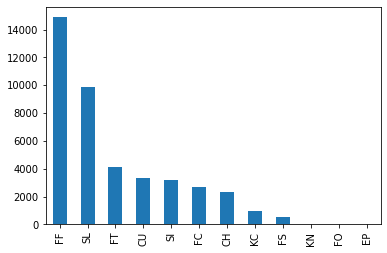

In [165]:
data_RtoR = data[(data['p_throws'] == 'R') & (data['stand'] == 'R')]
data_RtoR.pitch_type.value_counts().plot(kind='bar');

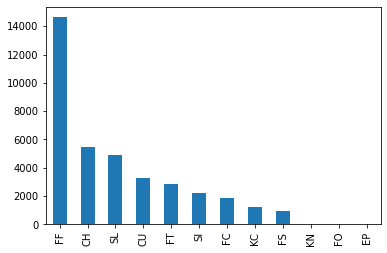

In [166]:
data_RtoL = data[(data['p_throws'] == 'R') & (data['stand'] == 'L')]
data_RtoL.pitch_type.value_counts().plot(kind='bar');

### Should I add labels and a title to the above plots and do the 4 plots need to be more compact by using subplots?
Right handed (RH) pitchers are throwing FF the most to both sides of the plate, but there's a clear difference betweeen 
the next most frequent pitch types! A RH batter receives a lot more sliders than a LH batter while a LH batter will see a changeup more than any other pitch except fastballs. What about left handed pitchers?

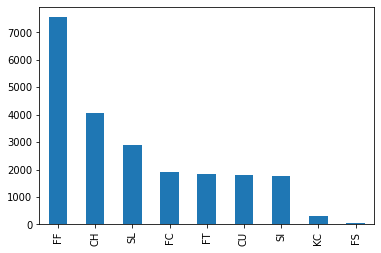

In [167]:
data_LtoR = data[(data['p_throws'] == 'L') & (data['stand'] == 'R')]
data_LtoR.pitch_type.value_counts().plot(kind='bar');

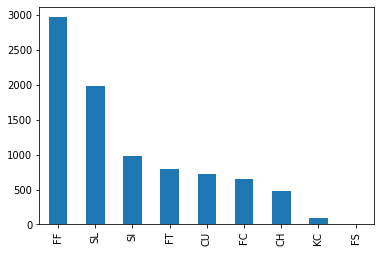

In [168]:
data_LtoL = data[(data['p_throws'] == 'L') & (data['stand'] == 'L')]
data_LtoL.pitch_type.value_counts().plot(kind='bar');

Not suprisingly, the reciprical is occuring with LH pitchers. This is due to the nature of how pitches move. A slider breaks down and away from a batter of the same orientation which is one of the more desired pitch locations to make a batter miss the ball. 

'type' is a short hand general reference to the result of each pitch: 

- B = ball 
- S = strike 
- X = in play

It won't make sense for us to use 'type' as a predictor for the 'pitch_type' as this is a post-pitch reference. We should try to incorporate previous 'type' along with previous 'pitch_type' as potential predictor variables. We'll revisit this later with our additional data transformation efforts.

In [35]:
data['type'].value_counts()

S    51879
B    39570
X    19166
Name: type, dtype: int64

'bb_type' indicates the type of batted ball. 'bb_type' will have a value only when 'type' = X (in play).

In [36]:
data['bb_type'].value_counts()

ground_ball    8344
line_drive     4802
fly_ball       4631
popup          1388
Name: bb_type, dtype: int64

The last 3 object features indicate the inning and fielding alignment for the infield and outfield. 

In [37]:
data['inning_topbot'].value_counts()

Top    56263
Bot    54352
Name: inning_topbot, dtype: int64

In [38]:
data['if_fielding_alignment'].value_counts()

Standard         71739
Infield shift    28271
Strategic        10592
Name: if_fielding_alignment, dtype: int64

In [39]:
data['of_fielding_alignment'].value_counts()

Standard          99249
Strategic         11267
4th outfielder       86
Name: of_fielding_alignment, dtype: int64

We'll keep all of our object features for now except for 'game_date'. There may be justification later to drop additional object features

### Feature Variables of type 'float64'

Now we'll begin exploring variables of numeric type.

In [169]:
data.select_dtypes('float64').columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'batter', 'pitcher',
       'zone', 'hit_location', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'hc_x',
       'hc_y', 'fielder_2', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'pitcher.1', 'fielder_2.1', 'release_pos_y', 'launch_speed_angle',
       'at_bat_number', 'pitch_number', 'home_score', 'away_score',
       'bat_score', 'fld_score', 'post_away_score', 'post_home_score',
       'post_bat_score', 'post_fld_score'],
      dtype='object')

One of two major benefits, and arguably the most valuable, in predicting pitch type is the knowledge of expected pitch speed. The other is ball movement and both are associated with pitch type. The data has reference to 2 speeds: release_speed and effective_speed. The release speed is measured by Statcast as the ball leaves the pitcher's hand, and the effective speed is a derived speed based on the extension of the pitcher's release.

In [170]:
data[['release_speed', 'effective_speed']].describe()

,release_speed,effective_speed
count,110327.000000,110612.000000
mean,88.742331,88.233588
std,5.966305,7.743009
min,50.800000,0.000000
25%,84.500000,84.000000
50%,90.000000,89.700000
75%,93.500000,93.500000
max,102.300000,103.500000


In [171]:
len(data['effective_speed'][data['effective_speed'] == 0])

289

A minimum speed of 0.0 doesn't make sense. Effective speed stats are skewed by 289 zero values so we'll filter for speeds greater than 0.

In [172]:
data.loc[data['effective_speed'] > 0, 'effective_speed'].describe()

count    110323.000000
mean         88.464723
std           6.297918
min          48.500000
25%          84.000000
50%          89.700000
75%          93.500000
max         103.500000
Name: effective_speed, dtype: float64

We can see the release speed and effective speed are very close. Given the definitions of the two speeds, we'll focus on release_speed moving forward.

'release_pos_x' is defined as the horizontal release position of the ball measured in feet from the catcher's perspective, and 'release_pos_z' is defined as the vertical release position of the ball measured in feet from the catcher's perspective. We can use these 2 values to graph a 2-D representation of release position for each pitch and differentiate between a pitcher that throws left handed from right handed with 'p_throws'.

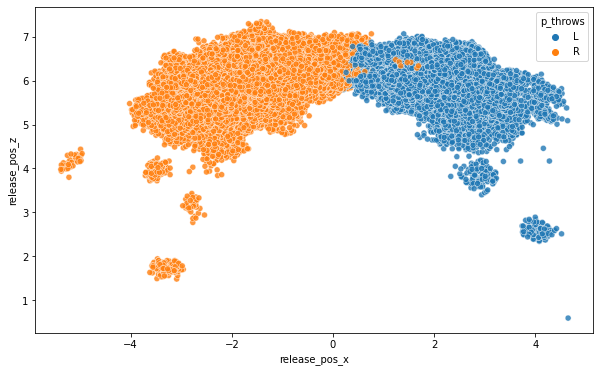

In [173]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='release_pos_x', y='release_pos_z', data=data, hue='p_throws', alpha=0.8);

While this is interesting, we can't rely on the position of the pitch to help determine 'pitch_type'. A 100 mph fastball will reach the plate in less than 500 milliseconds. This is obviously not enough time to identify the release position, predict the pitch, and communicate the prediction.

In [174]:
data.drop(columns=['release_pos_x', 'release_pos_z', 'effective_speed'], inplace=True)

'batter', 'pitcher', 'on_1b', 'on_2b', 'on_3b', 'fielder_2', 'fielder_2.1', and 'pitcher.1' are all numerical identifiers and so descriptive statistics are not meaningful. I suspect that 'fielder_2.1' and 'pitcher.1' are duplicates of 'fielder_2' and 'pitcher', so let's at least see what the stats look like for those:

In [175]:
data[['fielder_2', 'fielder_2.1', 'pitcher', 'pitcher.1']].describe()

,fielder_2,fielder_2.1,pitcher,pitcher.1
count,110615.000000,110615.000000,110615.000000,110615.000000
mean,545935.081842,545935.081842,572594.659793,572594.659793
std,66114.784146,66114.784146,67262.753649,67262.753649
min,425772.000000,425772.000000,282332.000000,282332.000000
25%,488771.000000,488771.000000,519443.000000,519443.000000
50%,547172.000000,547172.000000,592858.000000,592858.000000
75%,595978.000000,595978.000000,621366.000000,621366.000000
max,669257.000000,669257.000000,673633.000000,673633.000000


Confirmed! The fields have identical descriptive statistics and can be considered duplicate columns. 

In [176]:
data.drop(columns=['fielder_2.1', 'pitcher.1'], inplace=True)

The count of balls, strikes, and outs are fundamental metrics in baseball. For any given pitch, there should be a maximum of 3 balls, 2 strikes, and 2 outs. When a pitch results in a 4th ball, 3rd strike, or 3rd out, the batter changes and the pitch count will reset. We don't see those counts in the data because it is pre-pitch data that we're working with, as desired.

In [177]:
data[['balls', 'strikes', 'outs_when_up']].describe()

,balls,strikes,outs_when_up
count,110615.000000,110615.000000,110615.000000
mean,0.882602,0.901894,0.978782
std,0.968063,0.828099,0.817827
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,3.000000,2.000000,2.000000


In [178]:
data[['balls', 'strikes', 'outs_when_up']].isnull().sum()

balls           0
strikes         0
outs_when_up    0
dtype: int64

These features appear as expected and do not have any null values to address. *What does the pitch distribution look like for the variety of these features?*

The 'hit_location' is an integer value (1-9) for the position player that first touches the hit ball. 'zone', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'release_spin_rate', 'release_extension', 'release_pos_y', 'launch_speed_angle' are all movement, position, or velocity references to the pitch or hit ball. While some of these features will certainly help predict pitch type, it wouldn't be practical for our use as the pitch has to occur in order to gather this information. Our aim is to predict 'pitch_type' with only the information we have before a pitch is thrown.  

In [180]:
data.drop(columns=['hit_location', 'zone', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'hc_x', 'hc_y', 'vx0', 'vy0', 'vz0', 
                   'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 
                   'release_spin_rate', 'release_extension', 'release_pos_y', 'launch_speed_angle'], inplace=True)

Finally, we know that the last 4 object categories starting with 'post_' are post-pitch references and again do not align 
with our intentions.

In [181]:
data.drop(columns=['post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score'], inplace=True)

In [182]:
data.select_dtypes('float64').columns

Index(['release_speed', 'batter', 'pitcher', 'balls', 'strikes', 'on_3b',
       'on_2b', 'on_1b', 'outs_when_up', 'inning', 'fielder_2', 'game_pk',
       'at_bat_number', 'pitch_number', 'home_score', 'away_score',
       'bat_score', 'fld_score'],
      dtype='object')

In [185]:
print(data.columns)
len(data.columns)

Index(['pitch_type', 'release_speed', 'batter', 'pitcher', 'events',
       'description', 'stand', 'p_throws', 'type', 'bb_type', 'balls',
       'strikes', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning',
       'inning_topbot', 'fielder_2', 'game_pk', 'at_bat_number',
       'pitch_number', 'pitch_name', 'home_score', 'away_score', 'bat_score',
       'fld_score', 'if_fielding_alignment', 'of_fielding_alignment'],
      dtype='object')


29

We know have less than 30 features plus our target feature. Let's dive into our target feature, 'pitch_type'. We'll see what we can discover within and how 'pitch_type' relates to other features.

### Target Variable: pitch_type

We start by diving into our target feature, 'pitch_type'. Pitch type is defined as the type of pitch derived from Statcast. It is possible that the Statcast system occasionally misclassifies a pitch type but we may not have a way to determine if and when this happens. The statcast pitch type abbreviations are associated with the following pitch types:

- Changeup (CH)
- Curveball (CU)
- Cutter (FC)
- Eephus (EP)
- Forkball (FO)
- Four-Seam Fastball (FF)
- Knuckleball (KN)
- Knuckle-curve (KC)
- Screwball (SC)
- Sinker (SI)
- Slider (SL)
- Splitter (FS)
- Two-Seam Fastball (FT)

In [186]:
data['pitch_type'].unique()

array(['SI', 'SL', 'FF', 'CH', 'FS', 'FC', 'FT', 'EP', 'CU', 'KC', nan,
       'FO', 'KN'], dtype=object)

Every pitch type except SC (screwball) is represented in the data. This is not surprising given the difficulty of throwing this pitch. In fact, New York Daily News reports no one has thrown a SC in 2019 as of 7/21/19. Our data is from July 2019.

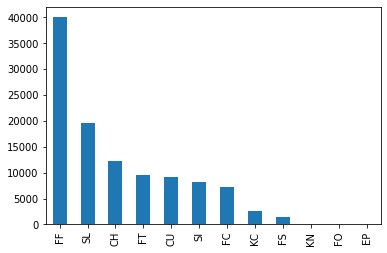

In [187]:
data.pitch_type.value_counts().plot(kind='bar');

FF is the most frequent pitch type with 36.3% of all pitches. SL and CH are the only other types with more than 10% at 17.8% and 11.2% respectively. 

In [188]:
pitch_counts = pd.concat([100 * data['pitch_type'].value_counts(normalize=True).round(3), 
                          data['pitch_type'].value_counts()], axis=1)
pitch_counts.columns = ['%', 'count']
pitch_counts

,%,count
FF,36.3,40020
SL,17.8,19666
CH,11.2,12350
FT,8.7,9638
CU,8.3,9160
SI,7.4,8181
FC,6.5,7153
KC,2.3,2586
FS,1.3,1480
KN,0.0,50


KN, FO, and EP have exceptionally low counts. This is expected as these 3 types of pitches are very difficult to throw and are rarely seen in MLB. Let's take a look at the pitchers that are capable of these pitches.

In [189]:
data.loc[data['pitch_type'] == 'KN', 'pitcher'].unique()

array([453214.])

In [190]:
data.loc[data['pitch_type'] == 'FO', 'pitcher'].unique()

array([571539.])

In [191]:
data.loc[data['pitch_type'] == 'EP', 'pitcher'].unique()

array([425844., 506433.])

One pitcher is responsible for each of the two types KN and FO. Somewhat unexpectedly given a count of 5, the EP pitch type was thrown by 2 different pitchers. The EP (eephus) is an extremely slow pitch that is usually thrown in jest or as an attempt to aggitate your opponent.

## Speed vs. Pitch Type

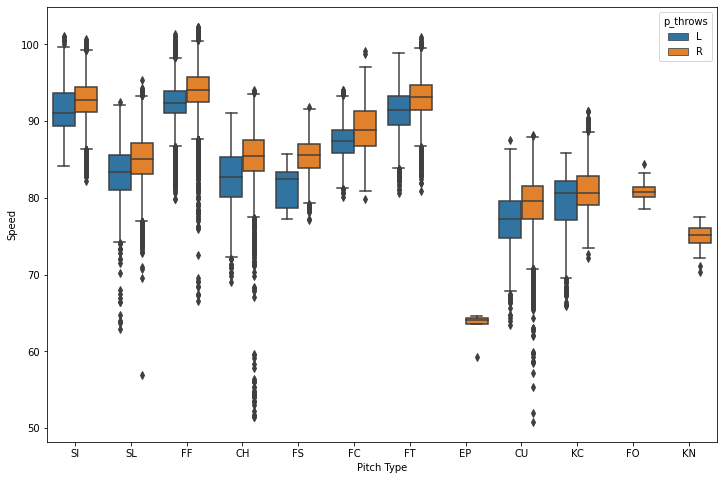

In [192]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='pitch_type', y='release_speed', hue='p_throws', data=data)
plt.xticks(rotation='horizontal')
plt.ylabel('Speed')
plt.xlabel('Pitch Type');

Here we can see how speed varies by pitch type. A batter's swing timing will depend on the speed of the pitch. The box plot above shows how a FF is much faster than a SL or CH. Note that right handed pitchers tend to throw faster pitches for all pitch types. They also have a larger range, especially on the slow end, than left handed pitchers. The range is most likely due to the higher count of right handers.

Pitch speed is not post-pitch data, so it won't be used to predict 'pitch_type'. Instead, this illustrates some of the value in predicting pitch type as a batter can be better prepared for the timing of his swing.

## Data Transformation

In [50]:
basics = data[['game_pk', 'at_bat_number', 'pitch_number', 'pitch_type', 'balls', 'strikes', 'outs_when_up', 'inning', 
               'on_3b', 'on_2b', 'on_1b']]
basics.head()

,game_pk,at_bat_number,pitch_number,pitch_type,balls,strikes,outs_when_up,inning,on_3b,on_2b,on_1b
index,,,,,,,,,,,
1778,567514.0,77.0,3.0,SI,0.0,2.0,2.0,9.0,NaN,444482.0,572233.0
1839,567514.0,77.0,2.0,SL,0.0,1.0,2.0,9.0,NaN,444482.0,572233.0
1867,567514.0,77.0,1.0,SL,0.0,0.0,2.0,9.0,NaN,444482.0,572233.0
1932,567514.0,76.0,4.0,FF,3.0,0.0,2.0,9.0,NaN,444482.0,NaN
1956,567514.0,76.0,3.0,FF,2.0,0.0,2.0,9.0,NaN,444482.0,NaN


In [62]:
pitches = pd.pivot(basics, index=['game_pk', 'at_bat_number'], columns='pitch_number', values='pitch_type')

In [63]:
pitches.head()

pitch_number           1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 11.0  \
game_pk  at_bat_number                                                          
564777.0 1.0             CH   CH   CH   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         2.0             FF   SL   FC   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         3.0             SL   FF   FF   FF  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         4.0             SI   FC   CH   CH   KC   FF   FC  NaN  NaN  NaN  NaN   
         5.0             SI  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

pitch_number           12.0 13.0  
game_pk  at_bat_number            
564777.0 1.0            NaN  NaN  
         2.0            NaN  NaN  
         3.0            NaN  NaN  
         4.0            NaN  NaN  
         5.0            NaN  NaN

In [64]:
pitches['sequence'] = pitches[pitches.columns[0:]].apply(
    lambda x: ','.join(x.dropna().astype(str)), axis=1)

In [65]:
pitches.head()

pitch_number           1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0 10.0 11.0  \
game_pk  at_bat_number                                                         
564777.0 1.0            CH   CH   CH   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         2.0            FF   SL   FC   CH  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         3.0            SL   FF   FF   FF  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
         4.0            SI   FC   CH   CH   KC   FF   FC  NaN  NaN  NaN  NaN   
         5.0            SI  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

pitch_number           12.0 13.0              sequence  
game_pk  at_bat_number                                  
564777.0 1.0            NaN  NaN           CH,CH,CH,CH  
         2.0            NaN  NaN           FF,SL,FC,CH  
         3.0            NaN  NaN           SL,FF,FF,FF  
         4.0            NaN  NaN  SI,FC,CH,CH,KC,FF,FC  
         5.0            NaN  NaN                    SI

In [103]:
pitches['sequence'].value_counts()

FF                               1222
FF,FF                             653
FF,FF,FF                          449
SL                                432
FT                                379
                                 ... 
SI,FS,SI,FS,SI,SI,FS                1
FC,CU,FF,FF,FC,FC,FF,FF,CU,FF       1
FC,CH,KC,SI                         1
CU,CH,CH,CU,CU,CU,SI                1
FF,SI,SL,SL                         1
Name: sequence, Length: 8401, dtype: int64

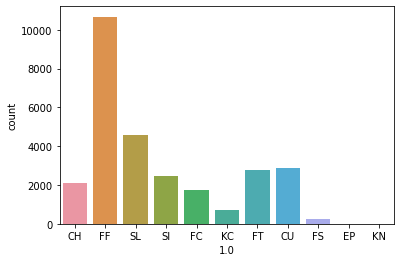

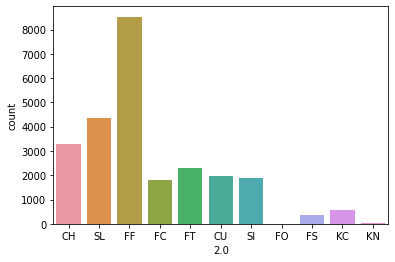

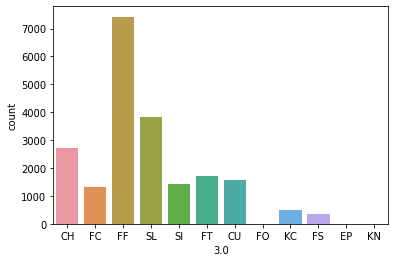

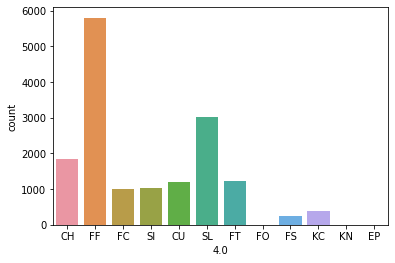

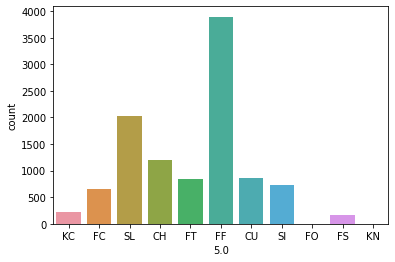

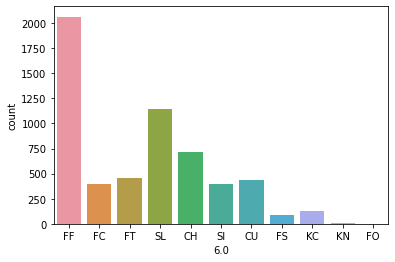

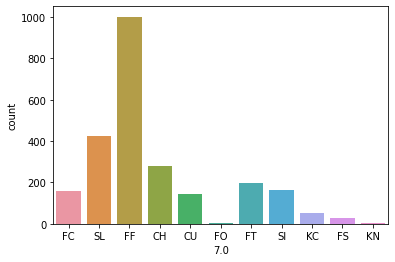

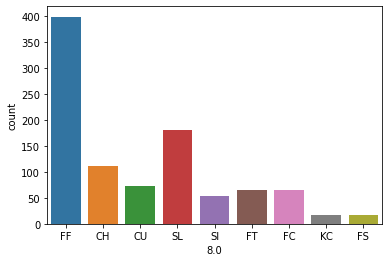

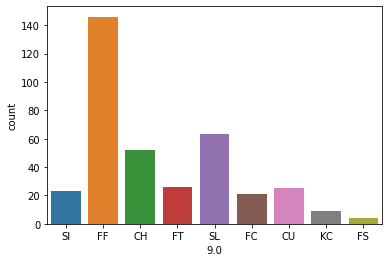

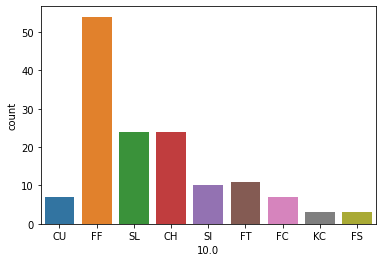

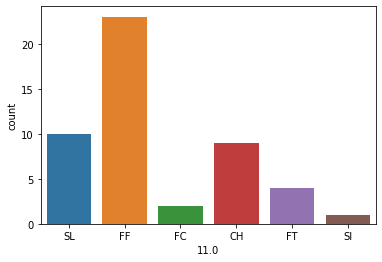

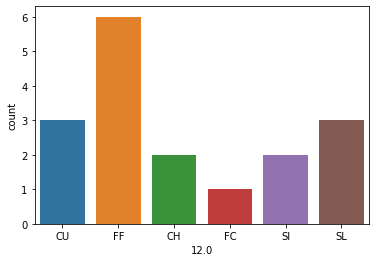

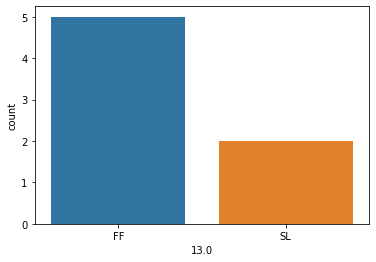

In [102]:
for pitch in range(1,14):
    sns.countplot(x=pitch, data=pitches)
    plt.show();

How many at-bats are there per game?

In [5]:
data.groupby('game_pk')['at_bat_number'].agg(max).mean()

77.42896174863388

 How many pitches per at-bat?

In [6]:
data.groupby(['game_pk', 'at_bat_number'])['pitch_number'].agg(max).mean()

3.9148823217129713